In [1]:
import sys, os
sys.path.append('..')
sys.path.append('.')

import yaml
import cdpam

from absl import logging
import IPython
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import tensorflow as tf
import ddsp.colab.colab_utils
from ddsp.spectral_ops import compute_mel, compute_logmel
import ddsp.training
import gin
import gin.tf
import gin.tf.external_configurables

#import wandb
#resume = False
#wandb_id = 'placeholder'
logging.set_verbosity(logging.INFO)

gin.external_configurable(tf.keras.regularizers.L1, module='tf.keras.regularizers')

# Imports for regnet
# import math
# import os
# import random
# import shutil
# import time

# import torch
# from torch import nn
# from torch.utils.data import DataLoader
# from Recorder import Recorder
# from data_utils import RegnetLoader, get_TSN_Data_set
# from criterion import RegnetLoss
# from model import Regnet, Modal_Response_Net
# # from test import test_checkpoint
# from contextlib import redirect_stdout
# from config import _C as config
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# from tqdm import tqdm

/juno/u/jyau/anaconda3/envs/diffimpactenv/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


tensorflow.python.keras.regularizers.L1

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
font_size = 20
plt.rcParams['font.size'] = font_size

fig_width = 6
fig_height = 4
def plot_spec(audio, size, vmin=-5,
             vmax=1,
             rotate=True, **matshow_kwargs):
    print('audio shape: ', audio.shape)
    if len(audio.shape) == 2:
        audio = audio[0]
    logmag = ddsp.spectral_ops.compute_logmag(ddsp.core.tf_float32(audio), size=size)
    #print(np.max(logmag))
    f, t, Zxx = scipy.signal.stft(audio, train_sample_rate, nperseg=size, noverlap=int(0.75*size))
    # logmag = spectral_ops.compute_logmel(core.tf_float32(audio), lo_hz=8.0, bins=80, fft_size=size)
    # logmag = spectral_ops.compute_mfcc(core.tf_float32(audio), mfcc_bins=40, fft_size=size)
    if rotate:
        # logmag = np.rot90(np.log(np.abs(Zxx)))
        logmag = np.rot90(logmag)
    # Plotting.
    logmag = logmag[60:, :]
    plt.matshow(logmag,
              vmin=vmin,
              vmax=vmax,
              cmap=plt.cm.magma,
              aspect='auto',
              **matshow_kwargs)
    
    print(f.shape)
    
    skip_num = 20
    print(logmag.shape)
    plt.yticks(ticks=list((range(logmag.shape[0], 0, -skip_num))).reverse())
    tick_locs = np.arange(logmag.shape[0]-1, 0, -skip_num)
    ticks = np.arange(0, logmag.shape[0]-1, skip_num)
    print(ticks)
    print(f[ticks])
    t = np.arange(test_samples) / train_sample_rate
    plt.yticks(tick_locs, f[ticks].astype(np.int32))
    xtick_nums = np.arange(0, example_secs, 0.1)
    # xtick_locs = np.arange(0, logmag.shape[1], int(skip_num*1.5))
    #xtick_locs = (xtick_nums / example_secs * logmag.shape[1]).astype(np.int32)
    #xtick_nums = xtick_locs / logmag.shape[1] * example_secs
    #plt.xticks(xtick_locs, ['%0.2f'%d for d in xtick_nums])
    plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    # plt.yticks([])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)

In [3]:
# Eval with saved tensors
def generate_audio_testing(raw_gain, raw_freq, raw_dampings, modal_fir, reverb, impulse_profile,
                           gains, frequencies, dampings, modal_response,
                           noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='controls'):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse --> impact profile
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D?
#     impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    print("impulse profile shape: ", impulse_profile.shape) # force profile
    zero_freq = np.zeros_like(raw_freq)
    zero_gain = np.random.rand(1,256) #np.zeros_like(raw_gain)
    zero_damp = np.zeros_like(raw_dampings)
    
#     vid = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-glass-bowl-10-of-47'
#     raw_gain = np.load(os.path.join(freq_path, vid+"_gains_raw.npy"))
#     raw_freq = np.load(os.path.join(freq_path, vid+"_freqs_raw.npy"))
#     raw_dampings = np.load(os.path.join(freq_path, vid+"_dampings_raw.npy"))
    
    # Get modal response from raw freqs, gains, and dampings
    irc_scratch = modal_fir.get_controls(raw_gain, raw_freq, raw_dampings)
    ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
    
    # Get modal response from scaled (passed through get_controls) freqs, gains, dampings
    ir = modal_fir.get_signal(gains, frequencies, dampings)
    
    print("ir: ", ir)
    print("model's output modal response: ", modal_response)
    #print("ir_scratch: ", ir_scratch)
    # Convolve together for modal vibration sounds
    if scratch == 'raw':
        audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
    elif scratch == 'controls' or scratch =='control':
        audio = ddsp.core.fft_convolve(impulse_profile, ir)
    else:
        audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
    print("convolved shape: ", audio.shape)
    
    # Generate and add time constant noise
    # Note that in the context, clips.shape[0] is batch size (which is 1 for all testing here)
    # clips.shape[1] is the actual clip size (like 441000 for 10 seconds of 44100 audio sampling rate)
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)),
    #minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    # audio = ddsp.core.resample(audio, clips.shape[1], 'linear')
    # Note that the resample function will return shape [n_timesteps], which is the second parameter
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
    return audio

In [4]:
# Use this method!!!!!
def generate_audio(predictions, modal_fir, reverb, impulse_profile, gains, frequencies, dampings, modal_response,
                   noise, acceleration_scale, revc, audio_sample_rate, example_secs, output_dir, scratch='controls',
                   modal_fir_only=True):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse --> impact profile
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D
    print("tau_bias: ", predictions['tau_bias'])
    impc = impact.get_controls(predictions['magnitudes'], predictions['stdevs'], predictions['taus'], predictions['tau_bias'])
    impulse_profile_scratch = impact.get_signal(impc['magnitudes'], impc['taus'])
    
    # Check that the impulse profile generated is same as model output
    check = tf.math.equal(impulse_profile, impulse_profile_scratch)
    print(f"compared elements of modal response: {check}")
    if (not tf.reduce_all(check) == True):
        diff = impulse_profile - impulse_profile_scratch
        print("average difference: ", tf.math.reduce_mean(diff))
        print("original impulse profile: ", impulse_profile)
#     assert(tf.reduce_all(check) == True)
    print(f"element-wise comparison of network output impulse profile and from scratch: {tf.reduce_all(check)}")
    print("impulse profile shape: ", impulse_profile_scratch.shape) # force profile
    
    # Generate modal FIR --> modal response (object material sound)
    # TODO: To use "raw" normally again, make sure to switch this!!
    irc_scratch = modal_fir.get_controls(predictions['gains'], predictions['frequencies'], predictions['dampings'])
    ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
    #ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
    ir = modal_fir.get_signal(gains, frequencies, dampings)
    
    # Plotting the network output modal response
    print("Plotting convolve generated modal response")
#     output_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/modal_fir'
    os.makedirs(output_dir, exist_ok=True)
    begin_offset = int(train_sample_rate * 1.95)
    cutoff = int(train_sample_rate * 2.5)

    ir_plot = np.squeeze(ir_scratch) # modal response
    print(ir_plot.shape)
    ir_plot = ir_plot[begin_offset:cutoff]
    t2 = (np.arange(0, ir_plot.shape[0])  - (train_sample_rate * 2 - begin_offset)) / (2 * train_sample_rate)
    plt.plot(t2, ir_plot)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    fig = plt.gcf()
    fig.set_size_inches(fig_width+2, fig_height)
    if no_axis:
        ax = plt.gca()
        # ax.axes.yaxis.set_visible(False)
#         ax.axes.yaxis.set_ticks([])
        plt.xticks(fontsize=font_size-6)
    fig.savefig(os.path.join(output_dir, audio_title+f'_convolve_ir-material_id_{material_id}.png'), bbox_inches='tight')
    plt.show()

    print("model's output modal response: ", modal_response)
    print("ir_scratch: ", ir_scratch)
    print("ir: ", ir)
    
    check = tf.math.equal(modal_response, ir_scratch)
    print(f"compared elements of modal response: {check}")
    assert(tf.reduce_all(check) == True)
    print(f"element-wise comparison of network output modal response and from scratch: {tf.reduce_all(check)}")
    
    # Convolve together for modal vibration sounds
    if scratch == 'raw':
        audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
    elif scratch == 'controls':
        audio = ddsp.core.fft_convolve(impulse_profile, ir)
    else:
        audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
    print("convolved shape: ", audio.shape)
    
    if modal_fir_only:
        print("Return audio without adding noise, acceleration sound, or reverb")
        audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
        return audio
    
    # Generate and add time constant noise
    # Note that in the context, clips.shape[0] is batch size (which is 1 for all testing here)
    # clips.shape[1] is the actual clip size (like 441000 for 10 seconds of 44100 audio sampling rate)
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)), minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    # audio = ddsp.core.resample(audio, clips.shape[1], 'linear')
    # Note that the resample function will return shape [n_timesteps], which is the second parameter
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
    return audio

In [5]:
import scipy
def high_pass_filter(clip, fs):
    """
    fs is sampling frequency (audio sampling rate)
    """
    sos = scipy.signal.butter(10, 50, 'hp', fs=fs, output='sos')
    clip = scipy.signal.sosfiltfilt(sos, clip)
    return clip

Latest operative config used:  /juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/tapping-embed-vec-len-32-no-regularizer-high-pass-multiclass-last-training/operative_config-54000.gin
n modal frequencies: 256
Internal audio samples: 441000
-4
4.0
/juno/u/jyau/asmr-video-to-sound/data/asmr_all/high_pass/valid/*.wav
252
@ddsp.spectral_ops.compute_mfcc_mel_spec
80
n_out:  3
n_out:  903
input keys: ['audio']
input keys to MfccTimeRnnEncoder: ListWrapper(['audio'])
Z time steps: 252
rnn_channels:  512
tcnn kernel:  15
Input key to EmbeddingContextEncoder: material_id
Output key to EmbeddingContextEncoder: material_embedding


INFO:absl:Loaded checkpoint /juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/tapping-embed-vec-len-32-no-regularizer-high-pass-multiclass-last-training/ckpt-81000
INFO:absl:Loading model took 0.0 seconds


autoencoder preprocessor: None
autoencoder encoder: <ddsp.training.encoders.MultiEncoder object at 0x7f25b77ca910>
autoencoder decoder: <ddsp.training.decoders.MultiDecoder object at 0x7f24c5f970d0>
autoencoder processor group: <ddsp.processors.ProcessorGroup object at 0x7f25b778f2b0>
autoencoder loss objects: ListWrapper([<ddsp.losses.SpectralLoss object at 0x7f25b77a25e0>])
audio shape:  tf.Tensor([], shape=(0,), dtype=int32)
decoded audio first shape:  (440320, 1)
(1, 440320)
audio sample_rate:  tf.Tensor(44100, shape=(), dtype=int32)
loaded regnet spectrogram:  tf.Tensor(
[[[ -4.6640167  -4.4376917  -4.657637  ...  -5.5763907  -5.534535
    -5.5039816]
  [ -5.269692   -5.202071   -5.3686547 ...  -6.6260204  -6.457393
    -6.329332 ]
  [ -5.9478025  -6.020681   -6.210515  ...  -7.561914   -7.235946
    -7.0433598]
  ...
  [ -9.189067   -9.647817  -10.177416  ... -10.540081  -10.308248
   -10.080175 ]
  [ -9.463703   -9.99731   -10.536657  ... -10.793271  -10.520264
   -10.241188 ]
 

Plotting original waveform


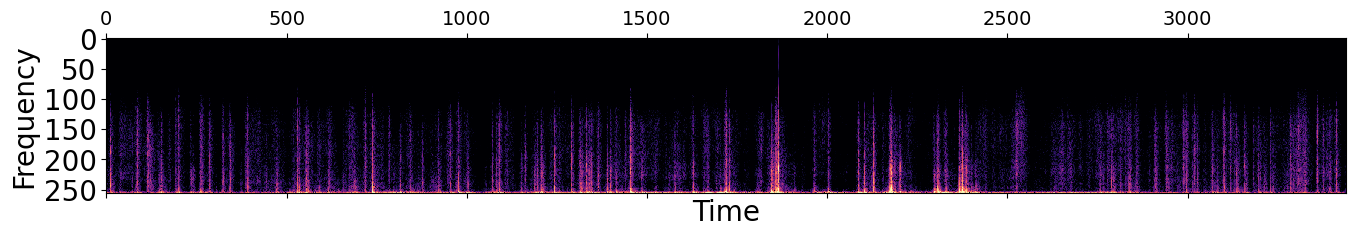

Going through autoencoder call
Input features to encoder: {'audio': <tf.Tensor: shape=(1, 80, 1720), dtype=float32, numpy=
array([[[ -4.6640167,  -4.4376917,  -4.657637 , ...,  -5.5763907,
          -5.534535 ,  -5.5039816],
        [ -5.269692 ,  -5.202071 ,  -5.3686547, ...,  -6.6260204,
          -6.457393 ,  -6.329332 ],
        [ -5.9478025,  -6.020681 ,  -6.210515 , ...,  -7.561914 ,
          -7.235946 ,  -7.0433598],
        ...,
        [ -9.189067 ,  -9.647817 , -10.177416 , ..., -10.540081 ,
         -10.308248 , -10.080175 ],
        [ -9.463703 ,  -9.99731  , -10.536657 , ..., -10.793271 ,
         -10.520264 , -10.241188 ],
        [ -9.827101 , -10.445708 , -11.0781145, ..., -11.297665 ,
         -11.0919695, -10.73494  ]]], dtype=float32)>, 'mel_spec': <tf.Tensor: shape=(1, 80, 1720), dtype=float32, numpy=
array([[[ -4.6640167,  -4.4376917,  -4.657637 , ...,  -5.5763907,
          -5.534535 ,  -5.5039816],
        [ -5.269692 ,  -5.202071 ,  -5.3686547, ...,  -6.6260204

Input after initial processing:  [<tf.Tensor: shape=(1, 252, 512), dtype=float32, numpy=
array([[[-0.1849759 , -0.00164526, -0.33970842, ..., -0.00332145,
         -0.10311667, -0.1616192 ],
        [-0.00334266, -0.06275617,  0.9400498 , ..., -0.10523184,
          0.6553621 , -0.14762662],
        [-0.16749385,  0.7675477 ,  0.16274166, ..., -0.0671218 ,
          0.27070022,  0.67909604],
        ...,
        [-0.30845377, -0.08406713,  0.14016251, ...,  0.28356454,
          0.04718114, -0.11733443],
        [ 0.33772647, -0.06427366,  0.10823852, ...,  0.40014738,
          0.09818035,  0.12809761],
        [-0.11780661,  0.39162734,  0.00996661, ...,  0.14165899,
          0.43500844,  1.0189577 ]]], dtype=float32)>]
x shape after concat:  (1, 252, 512)
shape after rnn:  (1, 252, 512)
after last concat:  (1, 252, 1024)
size of decoder output before split to dict:  (1, 252, 512)
size of decoder output before split to dict:  (1, 512)
shape after decoder:  {'audio': <tf.Tensor: shap

Current output keys (will be used for next processor input):  dict_keys(['inputs', 'audio', 'mel_spec', 'material_id', 'video_id', 'z', 'material_embedding', 'magnitudes', 'stdevs', 'taus', 'gains', 'frequencies', 'dampings', 'tau_bias', 'acceleration_scalar', 'reverb_gain', 'reverb_decay', 'noise_magnitudes', 'impact'])
Necessary input_keys:  ListWrapper(['gains', 'frequencies', 'dampings'])
Size of frequency envelope:  (1, 1, 256)
size of amplitude envelop:  (1, 256)
Size of frequency envelope:  (1, 44100, 256)
size of amplitude envelop:  (1, 44100, 256)
Current output keys (will be used for next processor input):  dict_keys(['inputs', 'audio', 'mel_spec', 'material_id', 'video_id', 'z', 'material_embedding', 'magnitudes', 'stdevs', 'taus', 'gains', 'frequencies', 'dampings', 'tau_bias', 'acceleration_scalar', 'reverb_gain', 'reverb_decay', 'noise_magnitudes', 'impact', 'modal_fir'])
Necessary input_keys:  ListWrapper(['impact/signal', 'modal_fir/signal'])
impulse response shape:  [1

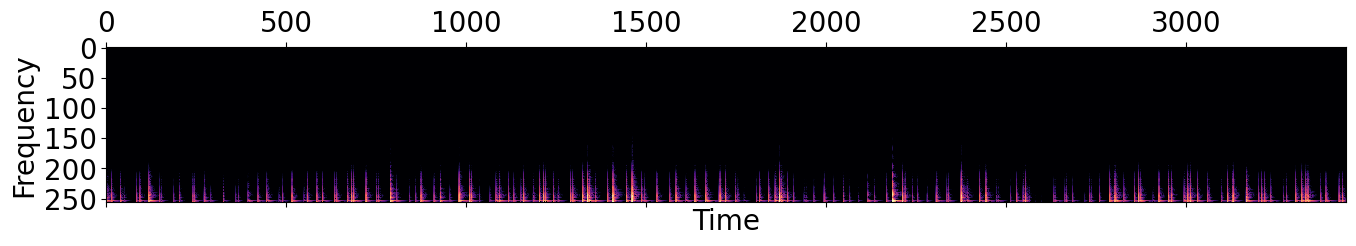

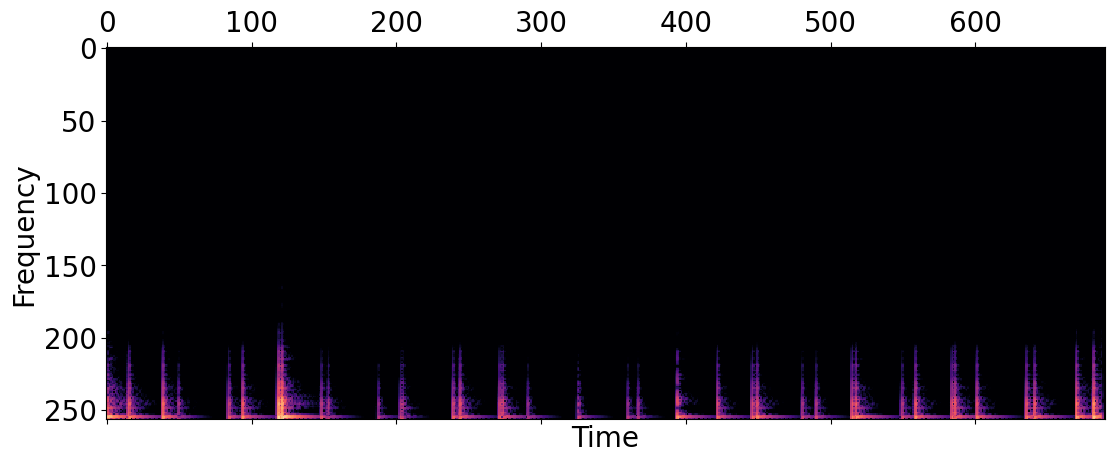

Output synth of the checkpoint from prediction[audio_synth]


passing through high pass filter...


keys of impact:  dict_keys(['signal', 'controls'])
Plotting impulse profile


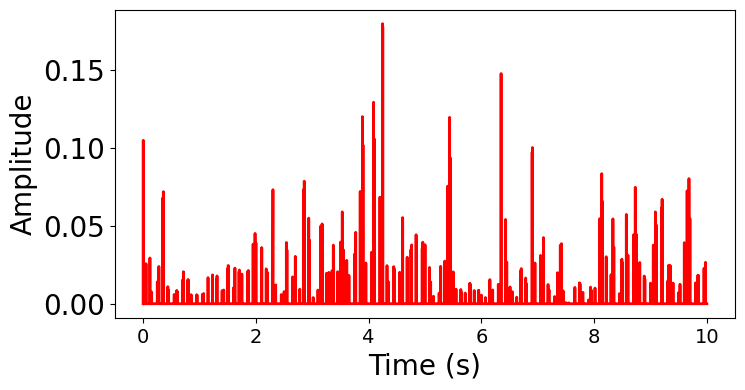

Plotting network output modal response
(88200,)


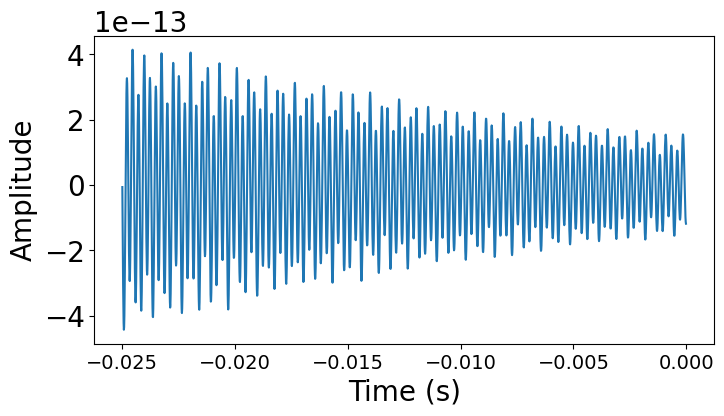

input shapes! impulse_profile: (1, 441000), ir: (1, 88200), noise: (1, 441000), revc: (1, 48000)
tau_bias:  tf.Tensor([[-0.43321687]], shape=(1, 1), dtype=float32)
method of resample:  window
n_frames: 253 and n_intervals: 252
dimensionts from the image resize output:  (1, 441000, 1)
final output of resample:  tf.Tensor(
[[[0.10150163]
  [0.10150157]
  [0.10150141]
  ...
  [0.02763666]
  [0.02763666]
  [0.02763666]]], shape=(1, 441000, 1), dtype=float32)
method of resample:  window
n_frames: 253 and n_intervals: 252
dimensionts from the image resize output:  (1, 441000, 1)
final output of resample:  tf.Tensor(
[[[0.00012006]
  [0.00012006]
  [0.00012006]
  ...
  [0.00013541]
  [0.00013541]
  [0.00013541]]], shape=(1, 441000, 1), dtype=float32)
compared elements of modal response: [[ True  True  True ...  True  True  True]]
average difference:  tf.Tensor(1.2504599e-07, shape=(), dtype=float32)
original impulse profile:  tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 441000), dtype=float

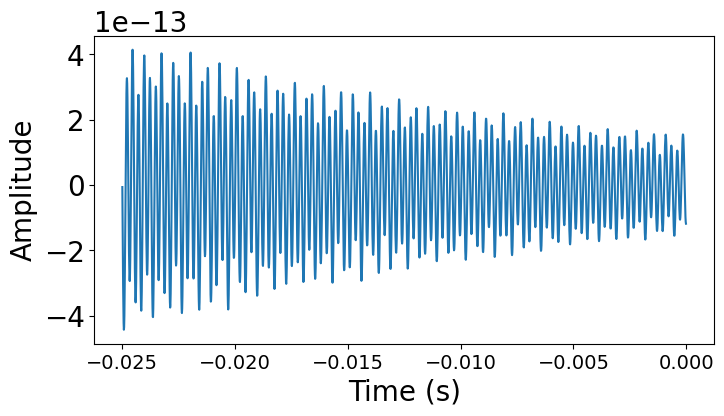

model's output modal response:  tf.Tensor(
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.7496643e-14
  -1.1245406e-13 -1.1836101e-13]], shape=(1, 88200), dtype=float32)
ir_scratch:  tf.Tensor(
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.7496643e-14
  -1.1245406e-13 -1.1836101e-13]], shape=(1, 88200), dtype=float32)
ir:  tf.Tensor(
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.7496643e-14
  -1.1245406e-13 -1.1836101e-13]], shape=(1, 88200), dtype=float32)
compared elements of modal response: [[ True  True  True ...  True  True  True]]
element-wise comparison of network output modal response and from scratch: True
impulse response shape:  [1, 1, 88200]
audio_frames shape:  (1, 1, 441000)
n_audio_frames: 1 and n_ir_frames: 1
convolved shape:  (1, 441000)
Return audio without adding noise, acceleration sound, or reverb
method of resample:  linear
n_timesteps: 441000 and outputs shape: 1
tf resample direct output shape:  (1, 441000, 1, 1)
dimensionts from the image

audio element-wise check:  tf.Tensor(False, shape=(), dtype=bool)
network audio synth: [[ 1.7018124e-06 -2.4520798e-06  2.9949445e-06 ... -1.6604579e-03
  -1.6557390e-03 -1.6514148e-03]]
convolve output: [[-5.2008563e-06 -5.7229354e-06 -5.5863816e-06 ... -1.6602876e-03
  -1.6632355e-03 -1.6553476e-03]]
differences: [[ 6.9026687e-06  3.2708556e-06  8.5813263e-06 ... -1.7031562e-07
   7.4964482e-06  3.9328588e-06]]
average of the differences:  tf.Tensor(1.3819236e-05, shape=(), dtype=float32)
Plotting audio synth waveform


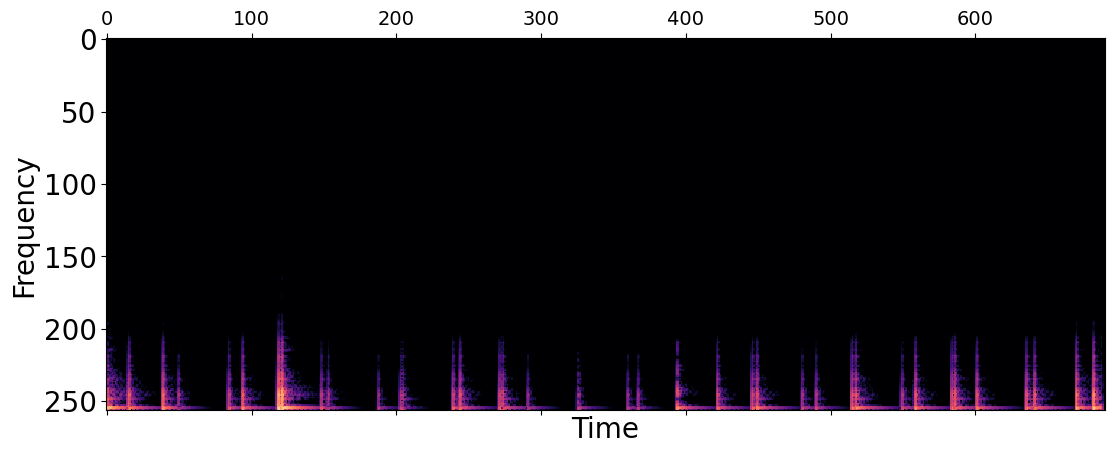

Plotting convolve waveform


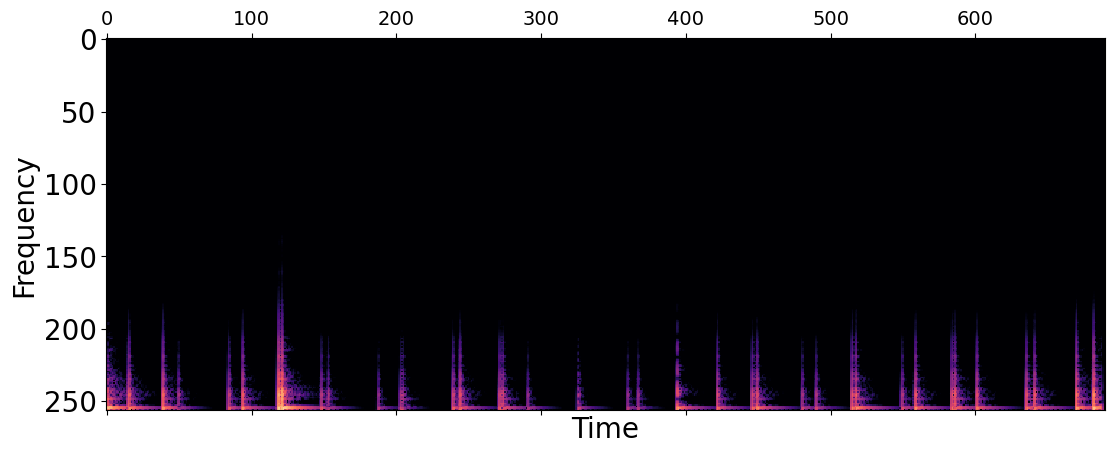

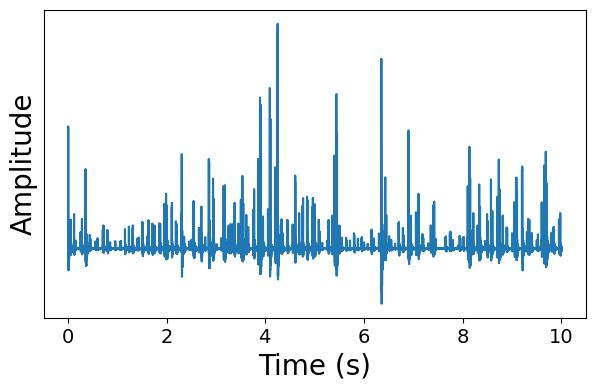

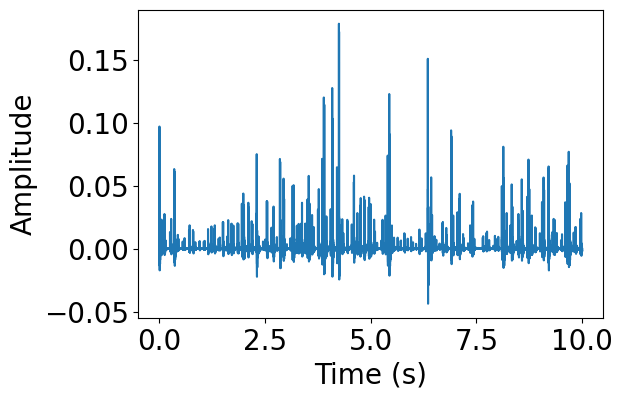

mags shape: (1, 252, 1)
stdevs shape: (1, 252, 1)
taus shape: (1, 252, 1)
num non-zeroes in taus:  tf.Tensor(252, shape=(), dtype=int64)
stdevs:  tf.Tensor(0, shape=(), dtype=int64)
magnitudes non zeros:  tf.Tensor(148, shape=(), dtype=int64)


In [6]:
# Test out the N_MODAL_FREQUENCIES=256 checkpoint for multiclass checkpoint
from IPython.display import display
no_axis = True

# Path to eval output
#eval_output = "/juno/u/jyau/regnet/ckpt/visual_extract_pipeline_rgb_only/checkpoint_075000/eval_output"
# Full pipeline
voc_type = "wood-box" #"silicone-pad" #"wooden-box" # wood-box
vocoder_type = 'silicon-coaster'  #'wooden-box'
# save_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/'
# save_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/sam-diffimpact-ckpts-multiclass/'
# save_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/sam-data-high-pass-multiclass-extra-4000-steps/'
# save_dir = f"/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/tapping-embed-vec-len-32-high-pass-multiclass"
# save_dir = f"/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/tapping-embed-vec-len-32-no-regularizer-high-pass-multiclass"
# save_dir = f"/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/tapping-embed-vec-len-32-no-regularizer-high-pass-multiclass-extended-training"
# save_dir = f"/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/tapping-embed-vec-len-32-no-regularizer-high-pass-multiclass-more-extended-training"
save_dir = f"/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/tapping-embed-vec-len-32-no-regularizer-high-pass-multiclass-last-training"
# save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/asmr/regnet-labels/1hr-{vocoder_type}'
# save_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/checkpoints/{voc_type}' # Sam's checkpoint
# save_dir = '/juno/u/jyau/regnet/ddsp/diffimpact/asmr/regnet-labels/train-all'
example_secs = 10
offset_secs = 0

latest_operative_config = ddsp.training.train_util.get_latest_operative_config(save_dir)
# latest_operative_config = os.path.join(save_dir, 'operative_config-0.gin')
gin.parse_config_file(latest_operative_config)
print("Latest operative config used: ", latest_operative_config)

n_modal_freq = gin.config.query_parameter('%N_MODAL_FREQUENCIES')
print(f"n modal frequencies: {n_modal_freq}")
#gin.config.bind_parameter('%N_MODAL_FREQUENCIES', 64)
#n_modal_freq = gin.config.query_parameter('%N_MODAL_FREQUENCIES')
#print(f"n modal frequencies: {n_modal_freq}")

train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

audio_sample_rate = train_sample_rate

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    # Change internal sample rate to be same as audio sample rate
    gin.config.bind_parameter('%INTERNAL_SAMPLE_RATE', gin.config.query_parameter('%AUDIO_SAMPLE_RATE'))
    
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
    print(f"Internal audio samples: {gin.config.query_parameter('%INTERNAL_AUDIO_SAMPLES')}")
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
# gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))
print(train_z_steps)


# Use Regnet predicted mel spectrogram as input
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.mel_bins', 80)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.spectral_fn', gin.config.parse_value("@ddsp.spectral_ops.compute_mfcc_mel_spec"))
print(gin.config.query_parameter('MfccTimeDistributedRnnEncoder.spectral_fn'))
print(gin.config.query_parameter('MfccTimeDistributedRnnEncoder.mel_bins'))

model = ddsp.training.models.get_model()
model.restore(save_dir)

# Loading and processing audio
MAX_WAV_VALUE = 32768.0

# audio_title = vid
# audio_title = "sIgkTYTWPz8-004-0000"
audio_title = "IlJYaR2D7GU-009-0000"
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-silicon-coaster-29-of-48'
# audio_title = "ASMR_Brain_Penetrating_3D_Tapping_No_Talking-101-of-240"
# audio_title = "compilation_final"
# audio_title = "The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-ceramic-17-of-22"
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-glass-bowl-34-of-47'
# audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-wooden-box-42-of-45"
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
#audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
try:
    audio = tf.io.read_file(f'/juno/u/jyau/regnet/ckpt/regnet_tapping_materials_medium_batch/val_last_ckpt_inference/checkpoint_100000_outputs/TrainAll/{audio_title}_synthesis.wav')
#     audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/audio_10s_44100hz_ddsp/1hr/{vocoder_type}/train/{audio_title}.wav')
except Exception as ex:
    audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/audio_10s_44100hz_ddsp/1hr/{vocoder_type}/val/{audio_title}.wav')
# audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/ASMR_Brain_3D_Tapping/audio_10s_44100hz/{audio_title}.wav')
#compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
#orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
#audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy")

print("audio shape: ", tf.shape(audio))
decoded_audio_init, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
print("decoded audio first shape: ", decoded_audio_init.shape)

#decoded_audio = decoded_audio * # Test by inputting zero vector audio
decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio_init[offset_samples:(offset_samples + test_samples)]), axis=0)
#decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio), axis=0)
print(decoded_audio.shape)
print("audio sample_rate: ", audio_sample_rate)

# Regnet spectrogram output
#reg_output_path = f'/juno/u/jyau/regnet/ckpt/regnet_baseline_asmr_by_material/val_inf_last_ckpt_waveglow_trainall/'
reg_output_path = f'/juno/u/jyau/regnet/ckpt/regnet_tapping_materials_medium_batch/val_last_ckpt_inference/'
spec = np.load(os.path.join(reg_output_path, f'{audio_title}.npy'))
spec = tf.expand_dims(tf.convert_to_tensor(spec), axis=0)
print("loaded regnet spectrogram: ", spec)
#spec = tf.transpose(spec, perm=[0,2,1])
print(spec.shape)
print(spec.shape[-1] == gin.config.query_parameter('MfccTimeDistributedRnnEncoder.mel_bins'))

material_id = 125
# test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[material_id], 'video_id':[0]}).batch(2)
test_input = tf.data.Dataset.from_tensor_slices({'audio':spec, 'mel_spec':spec, 'material_id':[material_id], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input)
display(IPython.display.Audio(data=decoded_audio, rate=int(train_sample_rate)))

# Plotting audio waveforms
print("Plotting original waveform")
output_dir = save_dir #f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/sam-diffimpact-ckpts-multiclass/'
# plot_spec(decoded_audio, 512)
ddsp.colab.colab_utils.specplot(decoded_audio, size=512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+'_orig_audio.png'), bbox_inches='tight')
plt.show()

# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
# Note that Sam's model uses mel_bins=128!
prediction = model(next(iter(test_input)), training=False)
print(f"prediction keys: {prediction.keys()}")
print("input audio shape: ", prediction['audio'].shape)
print("pred audio synth shape: ", prediction['audio_synth'].shape)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()

print("Output synth of the checkpoint from prediction[audio_synth]")
display(IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(train_sample_rate)))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

from scipy.io.wavfile import write
audio_path = f"{os.path.join(save_dir, audio_title+'_synth_'+ str(material_id) +'_.wav')}"
write(audio_path, audio_sample_rate, prediction['audio_synth'][:1, :].numpy().squeeze().astype('int16'))

# Sending synth output through high pass filter
clip = high_pass_filter(prediction['audio_synth'][:1, :], train_sample_rate)
print("passing through high pass filter...")
display(IPython.display.Audio(data=clip, rate=int(44100)))

# Generate audio by replacing the frequency with eval
#samplerate, data = wavfile.read(wav_fname)
# print(f"number of channels = {data.shape[1]}")
# number of channels = 2
# length = data.shape[0] / samplerate
# print(f"length = {length}s")
# length = 0.01s

# modal_fir = ddsp.synths.ModalFIR(n_samples=int(fs*sample_factor/1.0), sample_rate=int(fs*sample_factor),
#                             initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
# Note that clip is the data in example above, so clip.shape[0] is the length of the audio: seconds * sample rate
# impact = ddsp.synths.Impact(sample_rate=int(fs*sample_factor), n_samples=int(clip.shape[0]*sample_factor), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
# reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)
# Initialize modules
sample_factor = 1 # 2 if using doubled audio sampling rate for internal sample rate
modal_fir = ddsp.synths.ModalFIR(n_samples=int(sample_factor * train_sample_rate), sample_rate=int(sample_factor * train_sample_rate),
                            initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
# Impact synth can include_noise=True, which adds random noise based on stdevs, or not
impact = ddsp.synths.Impact(sample_rate=int(sample_factor * audio_sample_rate),
                            n_samples=int(sample_factor * (example_secs * audio_sample_rate)),
                            max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=False)
reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)

# Extracting important components from the Diffimpact prediction output
acceleration_scale = prediction['acceleration_scalar']
impulse_profile = prediction['impact']['signal']
ir = prediction['modal_fir']['signal'] # modal response
noise = prediction['filtered_noise']['signal']
revc = prediction['reverb']['controls']['ir'] #np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir'])))

# Plotting impact/force profile
print("keys of impact: ", prediction['impact'].keys())
print("Plotting impulse profile")
output_dir = os.path.join(save_dir, f'impact_profile_noaxis')
os.makedirs(output_dir, exist_ok=True)

# t2 = np.linspace(0, test_samples/train_sample_rate, test_samples * 2)
t2 = np.linspace(0, test_samples/train_sample_rate, test_samples)
plt.plot(t2, np.squeeze(prediction['impact']['signal']), c='red', linewidth=2)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
    
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
fig.savefig(os.path.join(output_dir, audio_title+f'_impact_signal_only-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

# Plotting the network output modal response
print("Plotting network output modal response")
output_dir = os.path.join(save_dir, f'modal_fir')
os.makedirs(output_dir, exist_ok=True)
begin_offset = int(train_sample_rate * 1.95)
cutoff = int(train_sample_rate * 2.5)

ir_plot = np.squeeze(prediction['modal_fir']['signal']) # modal response
print(ir_plot.shape)
ir_plot = ir_plot[begin_offset:cutoff]
t2 = (np.arange(0, ir_plot.shape[0])  - (train_sample_rate * 2 - begin_offset)) / (2 * train_sample_rate)
plt.plot(t2, ir_plot)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_ir-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

print(f"input shapes! impulse_profile: {impulse_profile.shape}, ir: {ir.shape}, noise: {noise.shape}, revc: {revc.shape}")

audio_final = generate_audio(prediction, modal_fir, reverb, impulse_profile,
                             prediction['modal_fir']['controls']['gains'],
                             prediction['modal_fir']['controls']['frequencies'],
                             prediction['modal_fir']['controls']['dampings'],
                             ir, noise, acceleration_scale, revc, audio_sample_rate, example_secs, output_dir,
                             scratch='raw',
                             modal_fir_only=True)

print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
display(IPython.display.Audio(data=audio_final, rate=int(train_sample_rate)))

# Save convolved audio
audio_path = f"{os.path.join(save_dir, audio_title+'_convolve_impact_modal_only_'+ str(material_id) +'.wav')}"
write(audio_path, audio_sample_rate, audio_final.numpy().squeeze().astype('int16'))

test_audio = tf.math.equal(prediction['audio_synth'], audio_final)
print("audio element-wise check: ", tf.reduce_any(test_audio))

if not tf.reduce_all(tf.math.equal(prediction['audio_synth'], audio_final)):
    print(f"network audio synth: {prediction['audio_synth']}")
    print(f"convolve output: {audio_final}")
    print(f"differences: {prediction['audio_synth'] - audio_final}")
    print('average of the differences: ', tf.math.reduce_mean(prediction['audio_synth'] - audio_final))

# Plotting audio waveforms
print("Plotting audio synth waveform")
output_dir = os.path.join(save_dir, f'final_audio')
os.makedirs(output_dir, exist_ok=True)
# plot_spec(prediction['audio_synth'][:1, :train_sample_rate*2], 512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_synth_wav-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

# Plotting audio waveforms
print("Plotting convolve waveform")
# plot_spec(audio_final[:1, :train_sample_rate*2], 512)
ddsp.colab.colab_utils.specplot(audio_final[:1, :train_sample_rate*2], size=512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_convolve_wav-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()


output_dir = os.path.join(save_dir, f'final_audio')
os.makedirs(output_dir, exist_ok=True)

plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+1, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_waveform-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()
plt.rcParams.update({
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.2),
})
plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, audio_title+f'_waveform_translucent-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

# Check shape of the impact info
print(f"mags shape: {prediction['magnitudes'].shape}")
print(f"stdevs shape: {prediction['stdevs'].shape}")
print(f"taus shape: {prediction['taus'].shape}")

print("num non-zeroes in taus: ", tf.math.count_nonzero(tf.math.round(prediction['taus'])))
print("stdevs: ", tf.math.count_nonzero(tf.math.round(prediction['stdevs']))) # only noise
print("magnitudes non zeros: ", tf.math.count_nonzero(tf.math.round(prediction['magnitudes'])))

In [7]:
# CDPAM loss
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = cdpam.CDPAM(dev=device)

print(audio_title)

# True ground truth, original audio from the video
gt = cdpam.load_audio(f'/juno/u/jyau/regnet/data/features/tapping/materials/audio_10s_44100hz/{audio_title}.wav')
print(train_sample_rate)
display(IPython.display.Audio(data=gt, rate=int(train_sample_rate)))

 # Load ground truth audio spec waveform
gt_wave = cdpam.load_audio(f'/juno/u/jyau/regnet/ckpt/regnet_tapping_materials_medium_batch/mel_spec_eval_gt/{audio_title}_gt_synthesis.wav')

ceramic_gt_wave = cdpam.load_audio(f'/juno/u/jyau/regnet/ckpt/regnet_tapping_materials_medium_batch/val_last_ckpt_inference_ceramic/checkpoint_100000_outputs/TrainCeramicPlate/{audio_title}_gt_synthesis.wav')

# Load predicted spec waveform
wave = cdpam.load_audio(f'/juno/u/jyau/regnet/ckpt/regnet_tapping_materials_medium_batch/val_last_ckpt_inference/checkpoint_100000_outputs/TrainAll/{audio_title}_synthesis.wav')
ceramic_wave = cdpam.load_audio(f'/juno/u/jyau/regnet/ckpt/regnet_tapping_materials_medium_batch/val_last_ckpt_inference_ceramic/checkpoint_100000_outputs/TrainCeramicPlate/{audio_title}_synthesis.wav')

# DiffImpact waveform
diff_wave = cdpam.load_audio(f"{os.path.join(save_dir, audio_title+'_synth_'+ str(material_id)+'_.wav')}")

# Calculate CDPAM loss
dist = loss_fn.forward(gt_wave, wave)
loss = dist.cpu().detach().numpy()
print("CDPAM loss between waveglow train all gt and waveglow train all pred: ", loss)

# Calculate CDPAM loss
dist = loss_fn.forward(gt_wave, diff_wave)
loss = dist.cpu().detach().numpy()
print(f"CDPAM loss between waveglow train all gt and diffimpact material id {material_id} of pred: ", loss)

# Calculate CDPAM loss
dist = loss_fn.forward(ceramic_gt_wave, ceramic_wave)
loss = dist.cpu().detach().numpy()
print(f"CDPAM loss between waveglow ceramic gt and waveglow ceramic pred: ", loss)

# Calculate CDPAM loss
dist = loss_fn.forward(ceramic_gt_wave, diff_wave)
loss = dist.cpu().detach().numpy()
print(f"CDPAM loss between waveglow ceramic gt and diffimpact material id {material_id} of pred: ", loss)

# Calculate CDPAM loss
dist = loss_fn.forward(gt, wave)
loss = dist.cpu().detach().numpy()
print(f"CDPAM loss between gt and waveglow train all pred: ", loss)

# Calculate CDPAM loss
dist = loss_fn.forward(gt, ceramic_wave)
loss = dist.cpu().detach().numpy()
print(f"CDPAM loss between gt and waveglow ceramic pred: ", loss)

# Calculate CDPAM loss
dist = loss_fn.forward(gt, diff_wave)
loss = dist.cpu().detach().numpy()
print(f"CDPAM loss between gt and diffimpact material id {material_id} of pred: ", loss)

IlJYaR2D7GU-009-0000
44100


CDPAM loss between waveglow train all gt and waveglow train all pred:  [0.7264103]
CDPAM loss between waveglow train all gt and diffimpact material id 125 of pred:  [0.22201258]
CDPAM loss between waveglow ceramic gt and waveglow ceramic pred:  [0.67988324]
CDPAM loss between waveglow ceramic gt and diffimpact material id 125 of pred:  [0.2476063]
CDPAM loss between gt and waveglow train all pred:  [0.75752765]
CDPAM loss between gt and waveglow ceramic pred:  [0.7567075]
CDPAM loss between gt and diffimpact material id 125 of pred:  [0.19693577]


In [8]:
# Get modal response with the audio dspy library
# import audio_dspy as adsp
# mel = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/melspec_10s_44100hz/{vid}_mel.npy')
# print(f'mel shape: {mel.shape} and audio sample rate: {audio_sample_rate}')
# freqs, gains = adsp.find_freqs(decoded_audio_init, audio_sample_rate, plot=True)

# obj = {}
# obj['frequencies'] = freqs
# obj['gains'] = gains
# obj['dampings'] = prediction['dampings']

# # Generate modal response, and convolve with the force profile, noise, and reverb
# print(f"freqs: {freqs.shape}, gains: {gains.shape}, damping: {prediction['dampings'].shape} noise: {noise.shape}, revc: {revc.shape}")
# audio_final = generate_audio(obj, modal_fir, reverb, impulse_profile,
#                              prediction['modal_fir']['controls']['gains'],
#                              prediction['modal_fir']['controls']['frequencies'],
#                              prediction['modal_fir']['controls']['dampings'],
#                              ir, noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='raw')
# print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
# display(IPython.display.Audio(data=audio_final, rate=int(train_sample_rate)))

In [9]:
# scratch = 'else'
# # Generate modal FIR --> modal response (object material sound)
# modal_response = prediction['modal_fir']['signal']
# irc_scratch = modal_fir.get_controls(prediction['gains'], prediction['frequencies'], prediction['dampings'])
# ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
# #ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
# ir = modal_fir.get_signal(prediction['modal_fir']['controls']['gains'],
#                           prediction['modal_fir']['controls']['frequencies'],
#                           prediction['modal_fir']['controls']['dampings'])
# print("ir: ", ir)
# print("model's output modal response: ", modal_response)
# print("ir_scratch: ", ir_scratch)
# # Convolve together for modal vibration sounds
# # Convolve together for modal vibration sounds
# if scratch == 'raw':
#     audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
# elif scratch == 'controls':
#     audio = ddsp.core.fft_convolve(impulse_profile, ir)
# else:
#     audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
# print("convolved shape: ", audio.shape)

# # Generate and add time constant noise
# audio += noise
# print("after adding noise: ", audio.shape)

# # Add acceleration sound
# audio += impulse_profile * acceleration_scale
# print("after acceleration sound: ", audio.shape)

# # Add reverb
# audio = reverb.get_signal(audio, revc)#revc['ir'])
# print("after reverb: ", audio.shape)

# # Downsample from internal sampling rate to original recording sampling rate
# print("audio sample rate: ", audio_sample_rate)
# audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
# display(IPython.display.Audio(data=audio, rate=int(train_sample_rate)))

In [10]:
# TODO: only after merging the regnet and ddsp models, otherwise they're using two different envs currently
# Load the trained frequency decoder model
# model = Modal_Response_Net()
# print("Initialized model")

# model.load_checkpoint(config.checkpoint_path)

# # Load data
# print("Getting the images to be stacked...")
# args.test_list = './filelists/asmr_by_material_1hr_train.txt' 
# trainset = get_TSN_Data_set(args)
# args.test_list = './filelists/asmr_by_material_1hr_test.txt'
# valset = get_TSN_Data_set(args)

# train_loader = DataLoader(trainset, num_workers=0, shuffle=True,
#                           batch_size=config.batch_size, pin_memory=False,
#                           drop_last=True)
# test_loader = DataLoader(valset, num_workers=0, shuffle=False,
#                          batch_size=config.batch_size, pin_memory=False)
# print("Check number of train examples: ", len(trainset))
# print("Check number of train loader examples: ", len(train_loader))
# assert(len(trainset) > 0)
# assert(len(train_loader) > 0)

In [11]:
# SpecGAN Vladimir evaluated sample check
# mel_check = np.load('/juno/u/jyau/SpecVQGAN/logs/2021-12-11T17-05-22_asmr_by_material_transformer/samples_None/VAS_validation/cls_1/ASMR_Addictive_Tapping_1_Hr_No_Talking-ceramic-plate-38-of-41_mel_sample_0.npy')
# print(mel_check.shape)
# ddsp.colab.colab_utils.specplot(mel_check, size=512)

# plt.figure()
# plt.imshow(mel_check,aspect='auto', origin='lower')
# plt.show()
#display(IPython.display.Audio(data=check, rate=int(44100)))